## Outline
1. Obtain 3D mesh data of animal models in different poses
2. Create reduced size point clouds with those meshes
4. Compute persistence diagrams from the point cloud data
5. Visualize persistence landscapes
6. Visualize persistence images
7. Use Multi Dimensional Scaling
8. Create persistence images to train on
9. Train multi-class SVM (one vs one) / evaluate
10. Train KNN / evaluate


https://people.csail.mit.edu/sumner/research/deftransfer/data.html#download




---



# **SETUP**
Here we install the necessary libraries and mount the notebook to google drive

In [1]:
# for persistence
!pip install ripser
!pip install persim
!pip install giotto-tda
!pip install scikit-tda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18101 sha256=7009e1ee70fae227cfd660a8cde90714bc8813c8d33ae318c2ff20c71a14d870
  Stored in directory: /root/.cache/pip/wheels/ef/0f/3b/0f931844eecc34addd90e72d54cd39c08b7066c5f25c00b9a4
Successfully built hopcroftkarp
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.4/526.4 kB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
from google.colab import auth
import requests
import zipfile
import os
import numpy as np
from ripser import ripser
from persim import PersistenceImager
import plotly.graph_objects as go

In [4]:
# This code will ask you to sign in to google drive.
# Once mounted, you can store and access data in your drive from this colab notebook.
drive.mount('/content/drive/')

Mounted at /content/drive/




---



# **Obtaining Data**

The 3D mesh data we will be using can be found at the website linked below. We have chosen several animal models to work with. Each comes in the form of a zipped file containing several .obj files reprsenting different poses of that animal. Each .obj file contains the following data:
- vertices (v) = x, y, z coordinates
- vertex Normals (vn) = directional components
- faces (f) = faces / polygons

For our project we will only be using the vertices (v) data.


In [5]:
# Obtaining data files from https://people.csail.mit.edu/sumner/research/deftransfer/data.html#download

# URLs of the desired zip files
zip_file_urls = [
    # Horse
    'https://people.csail.mit.edu/sumner/research/deftransfer/data/horse-poses.zip',
    # Camel
    'https://people.csail.mit.edu/sumner/research/deftransfer/data/camel-poses.zip',
    # Lion
    'https://people.csail.mit.edu/sumner/research/deftransfer/data/lion-poses.zip',
    # Flamingo
    'https://people.csail.mit.edu/sumner/research/deftransfer/data/flamingo-poses.zip',
    # Elephant
    'https://people.csail.mit.edu/sumner/research/deftransfer/data/elephant-poses.zip'
]

def download_and_extract_zip(url, extract_dir):
    # Send an HTTP request to the URL
    response = requests.get(url)
    # Check if the request was successful
    if response.status_code == 200:
        # Create a temporary file to store the downloaded zip file
        with open('temp.zip', 'wb') as file:
            file.write(response.content)
        # Extract the contents of the zip file
        with zipfile.ZipFile('temp.zip', 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"Zip file extracted successfully: {url}")
        # Remove the temporary zip file
        os.remove('temp.zip')
    else:
        print(f"Failed to download zip file: {url}")


In [6]:
# Define the directory where you want to extract the zip files
extract_dir = '/content/drive/My Drive/Topology_Project'

# Check if the directory exists
if not os.path.exists(extract_dir):
    # If the directory doesn't exist, create it
    os.makedirs(extract_dir)

    # Loop through each URL and download/extract the zip files
    for url in zip_file_urls:
        download_and_extract_zip(url, extract_dir)

    print("Zip files extracted successfully.")
else:
    print("The directory already exists. No need to extract zip files again.")

# FROM NOW ON YOU CAN ACCESS THE .obj FILES FROM YOUR DRIVE IN /content/drive/My Drive/Topology_Project

The directory already exists. No need to extract zip files again.




---



# **Parsing Data**

In [7]:
# loading / parsing .obj file data into vertices and triangle arrays
# this takes about a minute

def load_obj_file(file_path):
    vertices = []

    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('v '):  # Vertex line
                parts = line.split()
                # Extract vertex coordinates (one-based indices)
                vertex = [float(parts[1]), float(parts[2]), float(parts[3])]
                vertices.append(vertex)

    return vertices

def parse_obj_files_in_directory(directory):
    obj_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.obj') and not file.endswith('-reference.obj'):  # Check if not a reference file
                obj_files.append(os.path.join(root, file))
    return obj_files


obj_files_directory = '/content/drive/My Drive/Topology_Project'
obj_files = parse_obj_files_in_directory(obj_files_directory)

print(obj_files)

# Initialize a dictionary to store vertices and triangles data labeled by animal names and poses
labeled_data = {}

# Loop through each .obj file and load its data
for obj_file in obj_files:
    file_name = os.path.splitext(os.path.basename(obj_file))[0]  # Extract file name from file path
    animal_name, pose_name = file_name.split('-')  # Extract the animal name and pose name
    vertices = load_obj_file(obj_file)

    # Check if the animal entry exists in the labeled_data dictionary
    if animal_name not in labeled_data:
        labeled_data[animal_name] = {}  # Initialize a dictionary for the animal if it doesn't exist

    # Check if the pose entry exists for the animal
    if pose_name not in labeled_data[animal_name]:
        labeled_data[animal_name][pose_name] = {"vertices": []}  # Initialize data for the pose

    # Store the vertices and triangles data for the pose
    labeled_data[animal_name][pose_name]["vertices"] = vertices

    # Print some information if needed
    # print(f"Loaded {len(vertices)} vertices and {len(triangles)} triangles from {obj_file}")

# Now, you have access to all data separately for each animal and pose


['/content/drive/My Drive/Topology_Project/horse-poses/horse-01.obj', '/content/drive/My Drive/Topology_Project/horse-poses/horse-09.obj', '/content/drive/My Drive/Topology_Project/horse-poses/horse-04.obj', '/content/drive/My Drive/Topology_Project/horse-poses/horse-07.obj', '/content/drive/My Drive/Topology_Project/horse-poses/horse-02.obj', '/content/drive/My Drive/Topology_Project/horse-poses/horse-03.obj', '/content/drive/My Drive/Topology_Project/horse-poses/horse-10.obj', '/content/drive/My Drive/Topology_Project/horse-poses/horse-08.obj', '/content/drive/My Drive/Topology_Project/horse-poses/horse-06.obj', '/content/drive/My Drive/Topology_Project/horse-poses/horse-05.obj', '/content/drive/My Drive/Topology_Project/camel-poses/camel-01.obj', '/content/drive/My Drive/Topology_Project/camel-poses/camel-03.obj', '/content/drive/My Drive/Topology_Project/camel-poses/camel-02.obj', '/content/drive/My Drive/Topology_Project/camel-poses/camel-08.obj', '/content/drive/My Drive/Topology

In [8]:
print(labeled_data.keys())

dict_keys(['horse', 'camel', 'lion', 'flam', 'elephant'])


In [ ]:
# test for successful parsing of 10 horse .obj
# print("Outer Keys: ", labeled_data.keys())
# print()
# print("Inner Keys for 'horse': ", labeled_data['horse'].keys())
# print()
# print("Inner Keys for 'lion': ", labeled_data['lion'].keys())
# print()
# print("Inner Keys for 'elephant': ", labeled_data['elephant'].keys())
# print()
# print("Inner Keys for 'flamingo': ", labeled_data['flam'].keys())
# print()
# print("Inner Keys for 'camel': ", labeled_data['camel'].keys())

In [ ]:
# print(labeled_data['horse']['01'])
# print("number of points in 'horse''01':", len(labeled_data['horse']['01']['vertices']))
# print(len(labeled_data['horse']['01']['vertices']))



---


# DISPLAYING POINT CLOUDS

In [9]:
import plotly.graph_objects as go

# Loop through each horse pose
for pose_name, pose_data in labeled_data['horse'].items():
    # Get the vertices array for the current pose
    vertices_array = pose_data["vertices"]

    # Extract x, y, z coordinates from the vertices array
    x = [vertex[0] for vertex in vertices_array]
    y = [vertex[1] for vertex in vertices_array]
    z = [vertex[2] for vertex in vertices_array]

    # Create a 3D scatter plot for the current pose
    fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=2))])

    # Set the aspect ratio of the plot
    fig.update_layout(
        title=f"Point Cloud for Horse - Pose {pose_name}",
        scene=dict(
            xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
            aspectmode="manual",
            aspectratio=dict(x=0.4, y=0.9, z=1.2),  # Adjust aspect ratio as needed
            camera=dict(
                eye=dict(x=1, y=0, z=1),  # Set camera position (zoomed out)
                up=dict(x=0, y=1, z=0),    # Set up vector (z-axis)
                projection=dict(type='orthographic')  # Set projection to orthographic for straight axes
            )
        )
    )

    # Display the plot
    fig.show()




---


# Reduce size of point clouds

In [10]:
import numpy as np

# Initialize a dictionary to store the reduced point clouds
reduced_labeled_data = {}

# Define the size of the subset for random sampling
subset_size = 1000  # Adjust this number as needed

# Randomly sample subset_size points from each point cloud for each animal and pose
for animal_name, poses_data in labeled_data.items():
    reduced_labeled_data[animal_name] = {}
    for pose_name, data in poses_data.items():
        # Access the vertices array for the current pose
        vertices_array = data["vertices"]

        # Check if the vertices array has enough points for sampling
        if len(vertices_array) > subset_size:
            # Randomly sample subset_size points from the vertices array
            subset_indices = np.random.choice(len(vertices_array), subset_size, replace=False)
            reduced_vertices_array = [vertices_array[i] for i in subset_indices]
        else:
            # If the vertices array has fewer points than the subset size, use all points
            reduced_vertices_array = vertices_array

        # Store the reduced vertices array in the dictionary with the pose name as the key
        reduced_labeled_data[animal_name][pose_name] = {"vertices": reduced_vertices_array}

# Now reduced_labeled_data is a dictionary where the keys are animal names,
# the values are dictionaries where keys are pose names, and the values are reduced point clouds


In [ ]:
# # test for successful parsing of 10 horse .obj
# print("Outer Keys: ", reduced_labeled_data.keys())
# print()
# print("Inner Keys for 'horse': ", reduced_labeled_data['horse'].keys())
# print()
# print("Inner Keys for 'lion': ", reduced_labeled_data['lion'].keys())
# print()
# print("Inner Keys for 'elephant': ", reduced_labeled_data['elephant'].keys())
# print()
# print("Inner Keys for 'flamingo': ", reduced_labeled_data['flam'].keys())
# print()
# print("Inner Keys for 'camel': ", reduced_labeled_data['camel'].keys())

In [ ]:
# print(reduced_labeled_data['horse']['01'])
# print("number of points in 'horse''01':", len(reduced_labeled_data['horse']['01']['vertices']))

In [11]:
import plotly.graph_objects as go

# Loop through each horse pose
for pose_name, pose_data in reduced_labeled_data['horse'].items():
    # Get the vertices array for the current pose
    vertices_array = pose_data["vertices"]

    # Extract x, y, z coordinates from the vertices array
    x = [vertex[0] for vertex in vertices_array]
    y = [vertex[1] for vertex in vertices_array]
    z = [vertex[2] for vertex in vertices_array]

    # Create a 3D scatter plot for the current pose
    fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=2))])

    # Set the aspect ratio of the plot
    fig.update_layout(
        title=f"Point Cloud for Horse - Pose {pose_name}",
        scene=dict(
            xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
            aspectmode="manual",
            aspectratio=dict(x=0.4, y=0.9, z=1.2),  # Adjust aspect ratio as needed
            camera=dict(
                eye=dict(x=1, y=0, z=1),  # Set camera position (zoomed out)
                up=dict(x=0, y=1, z=0),    # Set up vector (z-axis)
                projection=dict(type='orthographic')  # Set projection to orthographic for straight axes
            )
        )
    )

    # Display the plot
    fig.show()




---


# Creating Diagrams

In [12]:
import ripser

# Dictionary to store persistent homology results
persistent_homology = {}

# Iterate over each animal name and its pose names
for animal_name, pose_data in reduced_labeled_data.items():
    # Dictionary to store persistent homology results for the current animal
    persistent_homology[animal_name] = {}

    # Iterate over each pose name and its vertices
    for pose_name, vertices in pose_data.items():
        # Get the vertices array
        vertices_array = np.array(vertices['vertices'])  # Assuming there's only one array per pose

        # Compute persistent homology using Ripser
        diagrams = ripser.ripser(vertices_array)['dgms']

        # Store the persistence diagrams in the dictionary
        persistent_homology[animal_name][pose_name] = diagrams


In [ ]:
# print(type(reduced_labeled_data['horse']['01']['vertices']))
# print(reduced_labeled_data['horse']['01']['vertices'])

In [ ]:
# print(type(persistent_homology['horse']['01']))
# print(len(persistent_homology['horse']['01']))
# print(len(persistent_homology['horse']['01'][0]))
# print(len(persistent_homology['horse']['01'][1]))
# print(persistent_homology['horse']['01'][1][0])

## Displaying Diagrams

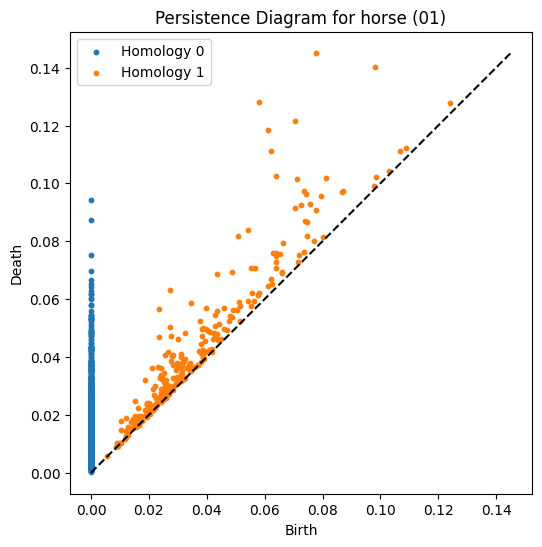

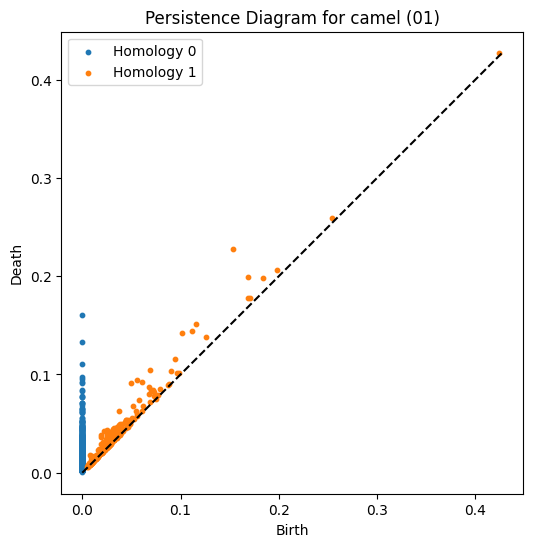

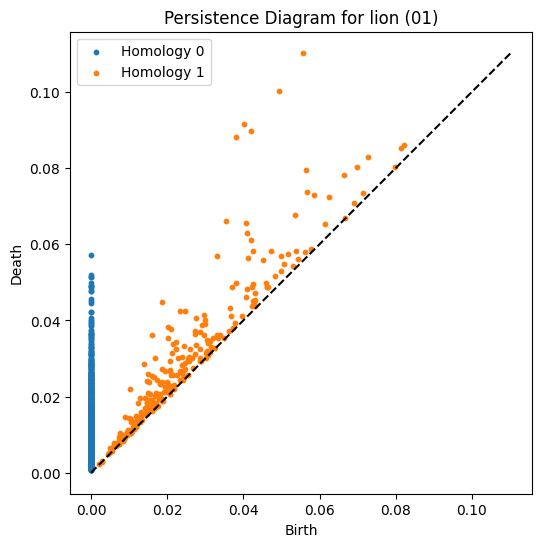

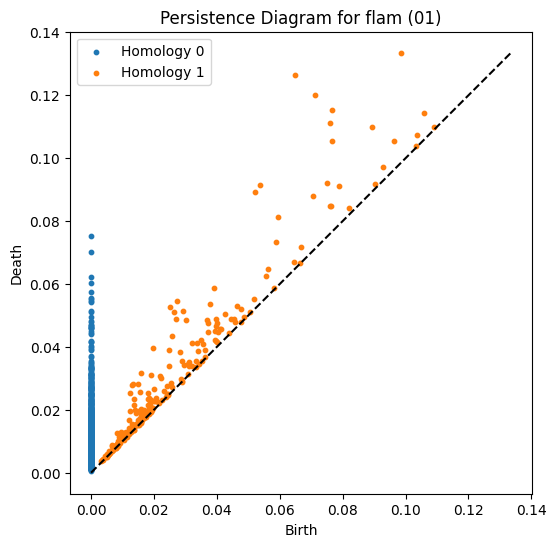

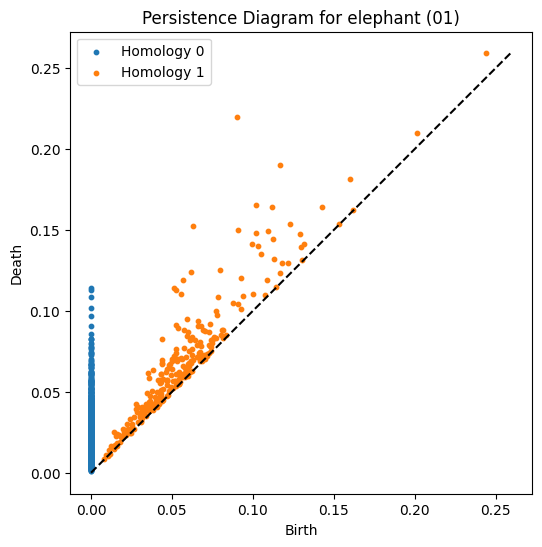

In [13]:
import numpy as np
import ripser
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)

def plot_persistence_diagrams_rotated_1(persistent_homology):
    # Iterate over each animal name and its rotated samples
    for animal_name, pose_data in persistent_homology.items():
        # Check if 'rotated_1' pose exists for the current animal
        if '01' in pose_data:
            # Get the persistence diagrams for the 'rotated_1' pose
            diagrams = pose_data['01']

            # Create a scatter plot for the persistence diagrams
            plt.figure(figsize=(6, 6))
            plt.title(f"Persistence Diagram for {animal_name} (01)")
            for i, diagram in enumerate(diagrams):
                birth, death = diagram.T
                plt.scatter(birth, death, label=f"Homology {i}", s=10)
            plt.xlabel("Birth")
            plt.ylabel("Death")
            plt.legend()
            plt.gca().set_aspect('equal', adjustable='box')
            plt.plot([0, max(birth.max(), death.max())], [0, max(birth.max(), death.max())], 'k--')
            plt.show()

# Call the function to plot persistence diagrams for 'rotated_1' pose
plot_persistence_diagrams_rotated_1(persistent_homology)




---



# Creating Landscapes

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from gtda.diagrams import PersistenceLandscape
from gtda.homology import VietorisRipsPersistence

In [15]:
import numpy as np
from gtda.diagrams import PersistenceLandscape
from gtda.homology import VietorisRipsPersistence

# Loop through each pose of horses
horse_poses = reduced_labeled_data.get('horse', {})  # Get all poses of horses
for pose_name, pose_info in horse_poses.items():
    # Extract the persistence diagram array
    persistence_diagram = np.array(pose_info['vertices'])  # Assuming one array per pose

    # Calculate persistence landscapes
    vr_pers = VietorisRipsPersistence()
    persistence_diagram = vr_pers.fit_transform([persistence_diagram])

    landscape = PersistenceLandscape(n_layers=10, n_bins=200)
    landscape_title = f"Horse Pose: {pose_name}"
    landscape.fit_transform_plot(persistence_diagram,plotly_params={'layout': {'title': landscape_title, 'width': 600.0, 'height': 600.0}})



---


# Persistence Images

In [16]:
from persim import PersistenceImager
from sklearn import datasets
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt

In [17]:
%matplotlib inline

In [18]:
from persim import PersistenceImager
import matplotlib.pyplot as plt

def plot_persistence_images(homology_data):
    # Initialize PersistenceImager
    pimgr = PersistenceImager(pixel_size=0.01)
    pimgr.fit(homology_data)
    pimgr.kernel_params = {'sigma': 0.0001}

    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(30, 10))

    # Plot diagram
    pimgr.pixel_size = 0.1
    pimgr.plot_diagram(homology_data, skew=True, ax=axs[0])
    axs[0].set_title('Diagram', fontsize=16)

    # Plot persistence image with pixel size 0.01
    pimgr.pixel_size = 0.01
    pimgr.plot_image(pimgr.transform(homology_data), ax=axs[1])
    axs[1].set_title('Pixel Size: 0.01', fontsize=40)

    # Plot persistence image with pixel size 0.001
    pimgr.pixel_size = 0.001
    pimgr.plot_image(pimgr.transform(homology_data), ax=axs[2])
    axs[2].set_title('Pixel Size: 0.001', fontsize=40)

    # Adjust layout
    plt.tight_layout()

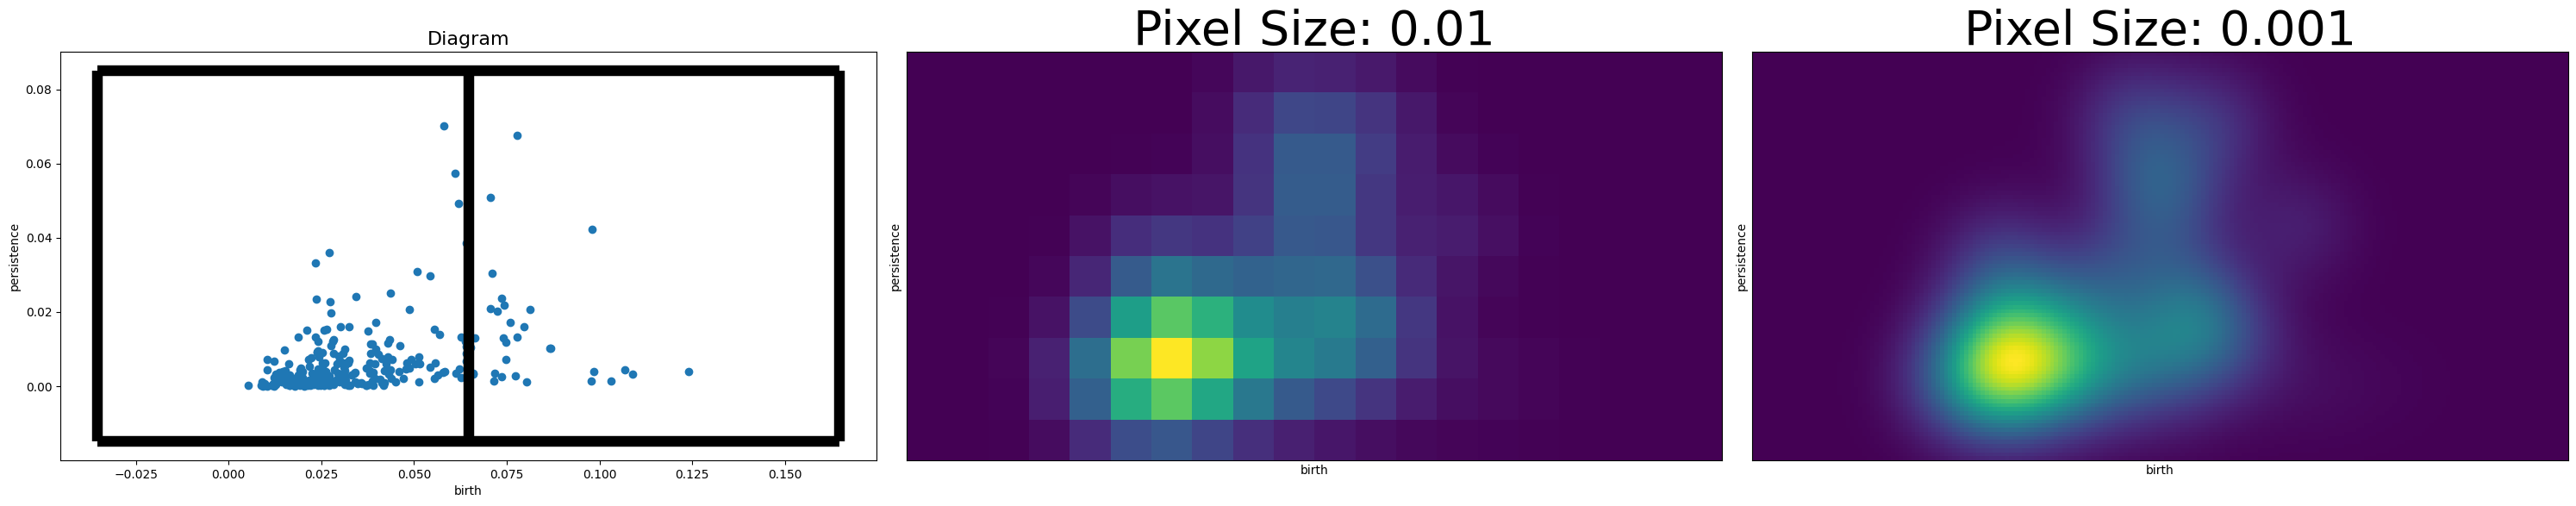

In [19]:
plot_persistence_images(persistent_homology['horse']['01'][1])


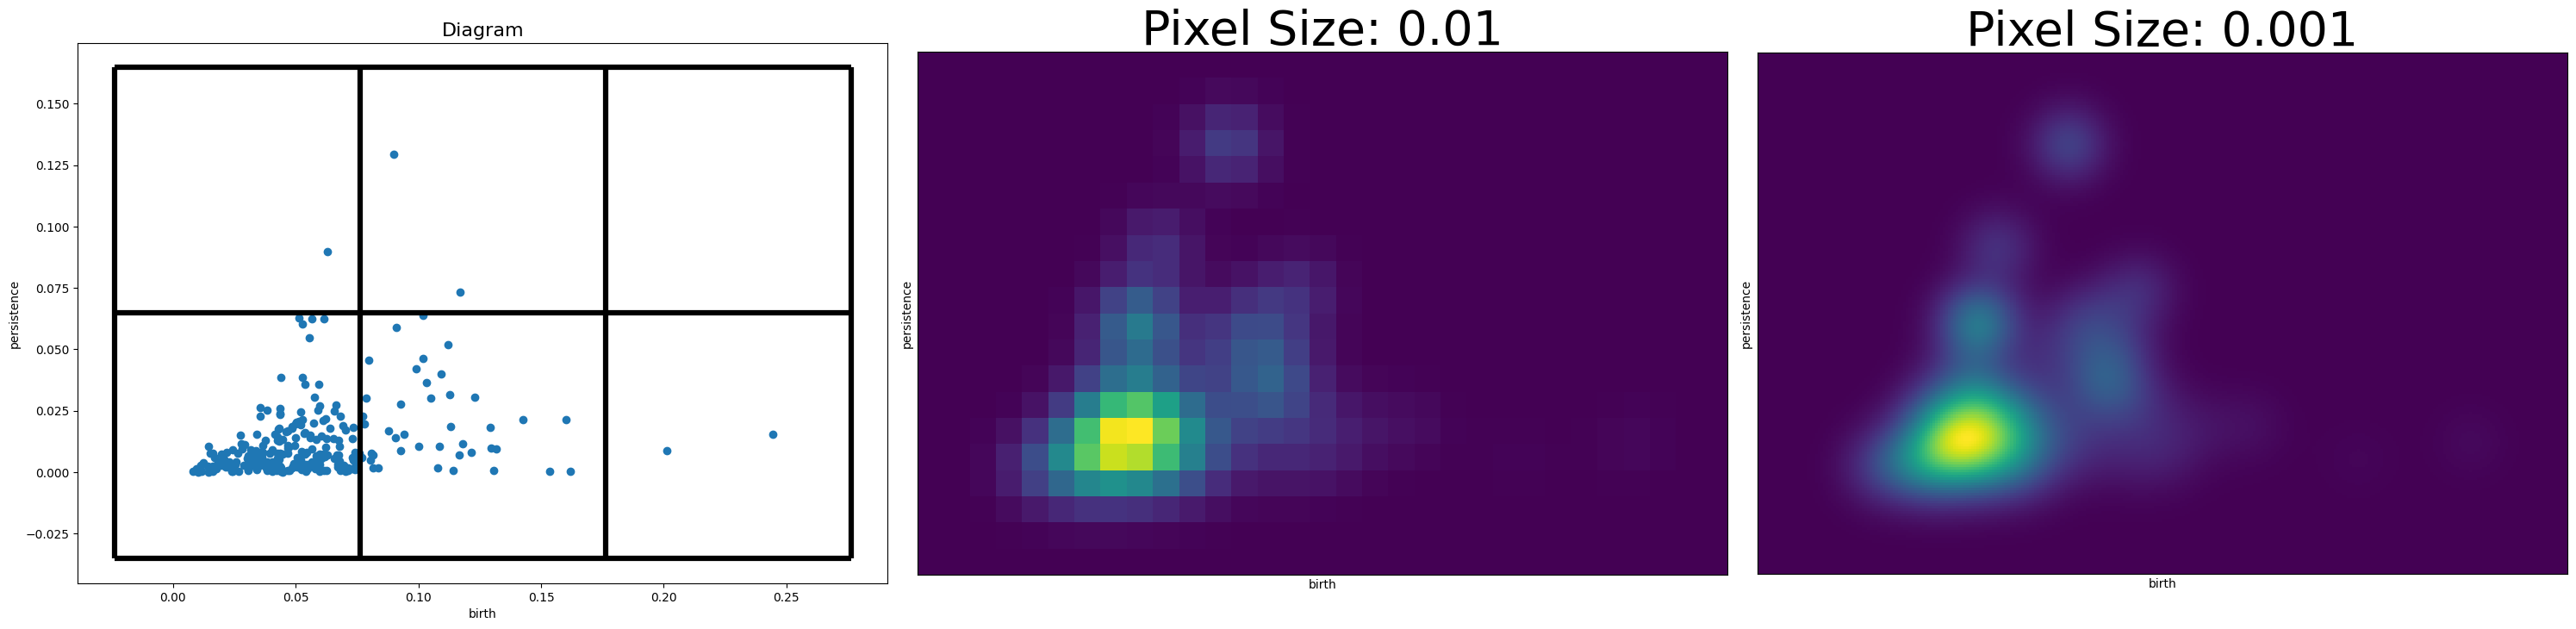

In [20]:
plot_persistence_images(persistent_homology['elephant']['01'][1])



---



In [21]:
print(((reduced_labeled_data['horse']['01']['vertices'])))


[[0.0959824, 0.485493, -0.373428], [0.1109, 0.415882, -0.0925732], [-0.0931973, 0.555703, 0.417707], [0.0945099, 0.301361, -0.442187], [-0.0952367, 0.385515, -0.179034], [-0.0599366, 0.348501, 0.131564], [0.0460888, 0.485137, 0.228191], [0.10669, 0.23206, -0.437487], [-0.0263022, 0.619561, 0.375482], [0.0537068, 0.376191, -0.254147], [-0.0463127, 0.716365, 0.425948], [0.00488651, 0.242419, 0.436978], [-0.100787, 0.558698, 0.413993], [-0.0688154, 0.430233, -0.166193], [0.118345, 0.0813272, -0.546905], [0.16265, 0.114683, -0.565588], [-0.0135333, 0.642923, 0.320091], [-0.129357, 0.119312, -0.150907], [-0.0441946, 0.62471, 0.0964301], [0.145132, 0.155619, -0.49422], [0.0260734, 0.595515, -0.711915], [-0.0479586, 0.720397, 0.429777], [-0.117412, 0.591362, 0.426508], [-0.120326, 0.545755, 0.419269], [0.0418377, 0.602141, -0.336345], [0.061416, 0.29706, 0.322517], [-0.0710605, 0.674623, 0.313316], [0.0861309, 0.334432, -0.323944], [-0.0463712, 0.363097, -0.288584], [-0.0136906, 0.743012, 0.4

In [22]:
for animal_name, pose_data in reduced_labeled_data.items():
    for pose_name, data in pose_data.items():
        vertices = np.array(data['vertices'])
print(vertices.shape)

(1000, 3)


In [23]:
from sklearn.manifold import MDS
import numpy as np
from sklearn.decomposition import PCA

# Initialize an empty list to store all point clouds for all animals
all_point_clouds = []

# Iterate over each animal in the dataset
for animal_name, pose_data in reduced_labeled_data.items():
    # Iterate over each pose of the current animal
    for pose_name, data in pose_data.items():
        # Extract the vertices (point cloud data) for the current pose
        vertices = data['vertices']
        # Convert the vertices to a numpy array and append to the list
        vertices_array = np.array(vertices)
        all_point_clouds.append(vertices_array)

# Convert the list of all point clouds to a numpy array
all_point_clouds = np.array(all_point_clouds)

In [24]:
print(all_point_clouds.shape)

(49, 1000, 3)


In [25]:
from sklearn.manifold import MDS

# Reshape the array to 2D
all_point_clouds_2d = all_point_clouds.reshape((-1, 2))

In [26]:
print(type(all_point_clouds))
print(all_point_clouds.shape)

<class 'numpy.ndarray'>
(49, 1000, 3)


In [ ]:
# Perform MDS
embedding = MDS(n_components=2)
X_t = embedding.fit_transform(all_point_clouds_2d)

In [ ]:
# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X_t[:, 0], X_t[:, 1])
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.title('MDS Visualization of Point Cloud Data')
plt.show()

ValueError: Found array with dim 3. MDS expected <= 2.



---


# Embedding / Multi Dimensional Scaling

In [27]:
from tqdm import tqdm
birth_death_data = []
for animal_name, pose_data in tqdm(persistent_homology.items()):
    for pose_name, PDs in pose_data.items():
            # Accessing birth and death data from the second array
            birth_death_data.append(PDs[1])

100%|██████████| 5/5 [00:00<00:00, 3610.80it/s]


In [28]:
lengths = []
for i in range(len(birth_death_data)):
  lengths.append(len(birth_death_data[i]))
  max_b = max(lengths)

In [29]:
pimgr = PersistenceImager(pixel_size=100,birth_range = (0,1), pers_range = (0,1))
pimgr.fit(birth_death_data)

In [30]:
pers_im_vectors = []
for i in tqdm(range(len(birth_death_data))):
  pers_im_vectors.append(pimgr.transform(birth_death_data[i], skew=False).flatten())

100%|██████████| 49/49 [00:00<00:00, 201.70it/s]


100%|██████████| 5/5 [00:00<00:00, 44057.82it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.

<ipython-input-31-0829067dd31c>:20: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

<ipython-input-31-0829067dd31c>:29: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



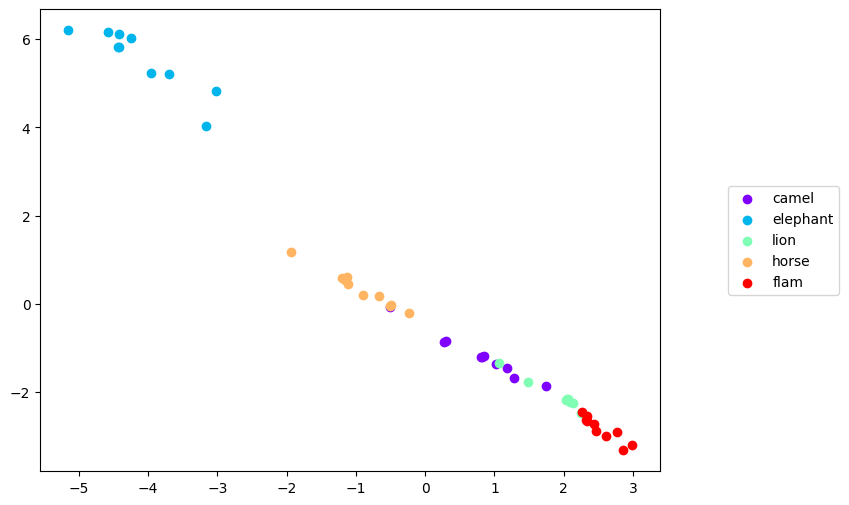

In [31]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm

# Assuming `persistent_homology` is your nested dictionary
labels = []  # List to store the labels
for animal_name, pose_data in tqdm(persistent_homology.items()):
    for pose_name, PDs in pose_data.items():
            labels.append(animal_name)

X = pers_im_vectors
embedding = MDS(n_components=2)
X_t = embedding.fit_transform(X)

# Get unique animal names as labels
unique_labels = list(set(labels))

# Create a colormap based on unique labels
cmap = mpl.cm.get_cmap('rainbow', len(unique_labels))

# Assign colors to each label
colors = [cmap(unique_labels.index(label)) for label in labels]

# Scatter plot
plt.figure(figsize=(8, 6))
for label in unique_labels:
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(X_t[indices, 0], X_t[indices, 1], c=cmap(unique_labels.index(label)), label=label)

# Legend
plt.legend(bbox_to_anchor=(1.3, 0.5), loc='center right')
plt.show()




---


# Training and Evaluating Models

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import image
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score

In [33]:
pers_ims_labeled = list(zip(labels, X))
pers_ims_df = pd.DataFrame(pers_ims_labeled, columns=['labels', 'persim'])

In [34]:
# Split data into training and testing data
imgs_train, imgs_test = train_test_split(pers_ims_df, test_size=0.2, stratify = labels)

In [35]:
X_train = list(imgs_train['persim'])
X_test = list(imgs_test['persim'])

Using One-VS-One technique for multi-class SVM

In [36]:
model = svm.SVC(kernel='linear', decision_function_shape='ovo').fit(X_train, imgs_train['labels'])
accuracy = model.score(X_test, imgs_test['labels'])
cm = confusion_matrix(imgs_test['labels'], model.predict(X_test))
print("Accuracy =",accuracy)
print("Confusion Matrix:")
print("Class:", labels[0], "  ",cm[0])
print("Class:", labels[10], "  ",cm[1])
print("Class:", labels[20], "   ",cm[2])
print("Class:", labels[30], "   ", cm[3])
print("Class:", labels[40], cm[4])

Accuracy = 1.0
Confusion Matrix:
Class: horse    [2 0 0 0 0]
Class: camel    [0 2 0 0 0]
Class: lion     [0 0 2 0 0]
Class: flam     [0 0 0 2 0]
Class: elephant [0 0 0 0 2]


In [37]:
model = svm.SVC(kernel='linear', decision_function_shape='ovo').fit(X_train, imgs_train['labels'])
accuracy = model.score(X_test, imgs_test['labels'])
cm = confusion_matrix(imgs_test['labels'], model.predict(X_test))
print("Accuracy =",accuracy)
print("Confusion Matrix:")
print("Class:", labels[0], "  ",cm[0])
print("Class:", labels[10], "  ",cm[1])
print("Class:", labels[20], "   ",cm[2])
print("Class:", labels[30], "   ", cm[3])
print("Class:", labels[40], cm[4])

Accuracy = 1.0
Confusion Matrix:
Class: horse    [2 0 0 0 0]
Class: camel    [0 2 0 0 0]
Class: lion     [0 0 2 0 0]
Class: flam     [0 0 0 2 0]
Class: elephant [0 0 0 0 2]


# KNN

In [38]:
from sklearn.neighbors import KNeighborsClassifier

# Train KNN classifier
k = 5  # Example: Number of neighbors to consider
model = KNeighborsClassifier(n_neighbors=k)
model.fit(X_train, imgs_train['labels'])

# Evaluate KNN classifier
accuracy = model.score(X_test, imgs_test['labels'])
cm = confusion_matrix(imgs_test['labels'], model.predict(X_test))
print("Accuracy =", accuracy)
print("Confusion Matrix:")
print("Class:", labels[0], "  ",cm[0])
print("Class:", labels[10], "  ",cm[1])
print("Class:", labels[20], "   ",cm[2])
print("Class:", labels[30], "   ", cm[3])
print("Class:", labels[40], cm[4])

Accuracy = 0.9
Confusion Matrix:
Class: horse    [2 0 0 0 0]
Class: camel    [0 2 0 0 0]
Class: lion     [0 0 2 0 0]
Class: flam     [0 0 0 2 0]
Class: elephant [0 0 1 0 1]


In [39]:
# Train KNN classifier
k = 1  # Example: Number of neighbors to consider
model = KNeighborsClassifier(n_neighbors=k)
model.fit(X_train, imgs_train['labels'])

# Evaluate KNN classifier
accuracy = model.score(X_test, imgs_test['labels'])
cm = confusion_matrix(imgs_test['labels'], model.predict(X_test))
print("Accuracy =", accuracy)
print("Confusion Matrix:")
print("Class:", labels[0], "  ",cm[0])
print("Class:", labels[10], "  ",cm[1])
print("Class:", labels[20], "   ",cm[2])
print("Class:", labels[30], "   ", cm[3])
print("Class:", labels[40], cm[4])

Accuracy = 0.8
Confusion Matrix:
Class: horse    [2 0 0 0 0]
Class: camel    [0 2 0 0 0]
Class: lion     [0 0 2 0 0]
Class: flam     [1 0 0 1 0]
Class: elephant [0 0 1 0 1]


In [40]:
# Train KNN classifier
k = 10  # Example: Number of neighbors to consider
model = KNeighborsClassifier(n_neighbors=k)
model.fit(X_train, imgs_train['labels'])

# Evaluate KNN classifier
accuracy = model.score(X_test, imgs_test['labels'])
cm = confusion_matrix(imgs_test['labels'], model.predict(X_test))
print("Accuracy =", accuracy)
print("Confusion Matrix:")
print("Class:", labels[0], "  ",cm[0])
print("Class:", labels[10], "  ",cm[1])
print("Class:", labels[20], "   ",cm[2])
print("Class:", labels[30], "   ", cm[3])
print("Class:", labels[40], cm[4])

Accuracy = 0.9
Confusion Matrix:
Class: horse    [2 0 0 0 0]
Class: camel    [0 2 0 0 0]
Class: lion     [0 0 2 0 0]
Class: flam     [0 0 0 2 0]
Class: elephant [0 0 1 0 1]
